# Access locations and times of Veery encounters

For this challenge, you will use a database called the [Global
Biodiversity Information Facility (GBIF)](https://www.gbif.org/). GBIF
is compiled from species observation data all over the world, and
includes everything from museum specimens to photos taken by citizen
scientists in their backyards.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Explore GBIF</div></div><div class="callout-body-container callout-body"><p>Before your get started, go to the <a
href="https://www.gbif.org/occurrence/search">GBIF occurrences search
page</a> and explore the data.</p></div></div>

> **Contribute to open data**
>
> You can get your own observations added to GBIF using
> [iNaturalist](https://www.inaturalist.org/)!

### Set up your code to prepare for download

We will be getting data from a source called [GBIF (Global Biodiversity
Information Facility)](https://www.gbif.org/). We need a package called
`pygbif` to access the data, which may not be included in your
environment. Install it by running the cell below:

In [3]:
%%bash
pip install pygbif

In [4]:
%conda list pygbif

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
pygbif                    0.6.4                    pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>In the imports cell, we’ve included some packages that you will need.
Add imports for packages that will help you:</p>
<ol type="1">
<li>Work with reproducible file paths</li>
<li>Work with tabular data</li>
</ol></div></div>

In [5]:
import time
import zipfile
from getpass import getpass
from glob import glob

import os
import pathlib

from getpass import getpass
from glob import glob

import geopandas as gpd
import pandas as pd

import pygbif.occurrences as occ
import pygbif.species as species

# get month names
import calendar

# libraries for Dynamic mapping
import geoviews as gv
import hvplot.pandas
import cartopy
import cartopy.crs as ccrs
import panel as pn
pn.extension()



/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'species',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'gbif_grus')
gbif_dir

'/home/jovyan/earth-analytics/data/species/gbif_grus'

:::

### Register and log in to GBIF

You will need a [GBIF account](https://www.gbif.org/) to complete this
challenge. You can use your GitHub account to authenticate with GBIF.
Then, run the following code to save your credentials on your computer.

> **Warning**
>
> Your email address **must** match the email you used to sign up for
> GBIF!

> **Tip**
>
> If you accidentally enter your credentials wrong, you can set
> `reset_credentials=True` instead of `reset_credentials=False`.

In [7]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'username'),
    GBIF_PWD=(getpass, 'password'),
    GBIF_EMAIL=(input, 'email'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

### Get the species key

> ** Your task**
>
> 1.  Replace the `species_name` with the name of the species you want
>     to look up
> 2.  Run the code to get the species key

In [8]:
# Query species
species_info = species.name_lookup('grus canadensis', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Antigone canadensis', 2474953)

In [9]:
species_key

2474953

### Download data from GBIF

::: {.callout-task title=“Submit a request to GBIF”

1.  Replace `csv_file_pattern` with a string that will match **any**
    `.csv` file when used in the `glob` function. HINT: the character
    `*` represents any number of any values except the file separator
    (e.g. `/`)

2.  Add parameters to the GBIF download function, `occ.download()` to
    limit your query to:

    -   observations
    -   from 2023
    -   with spatial coordinates.

3.  Then, run the download. **This can take a few minutes**. :::

    -   Can check progress at <https://www.gbif.org/user/download>.

In [10]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            "speciesKey = 2474953",
            "hasCoordinate = TRUE",
            "year = 2023",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

download key is 0020917-241007104925546
GBIF.org (17 October 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.4d3k48

In [11]:
gbif_path = glob(gbif_pattern)[0]
gbif_path

'/home/jovyan/earth-analytics/data/species/gbif_grus/0020917-241007104925546.csv'

### Load the GBIF data into Python

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load GBIF data</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Look at the beginning of the file you downloaded using the code
below. What do you think the <strong>delimiter</strong> is?</li>
<li>Run the following code cell. What happens?</li>
<li>Uncomment and modify the parameters of <code>pd.read_csv()</code>
below until your data loads successfully and you have only the columns
you want.</li>
</ol></div></div>

You can use the following code to look at the beginning of your file:

I copied from <https://github.com/lauren-alexandra/lauren-alexandra.github.io/blob/main/willow-flycatcher-distribution/willow-flycatcher-distribution.ipynb>
and Lauren Gleason

In [12]:
!head -n 2 $gbif_path 

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
4706403804	4fa7b334-ce0d-4e88-aaae-2e0c138d049e	URN:catalog:CLO:EBIRD:OBS1656610368	Animalia	Chordata	Aves	Gruiformes	Gruidae	Grus	Grus canadensis		SPECIES	Antigone canadensis (Linnaeus, 1758)	Antigone canadensis		US	Babcock-Webb WMA	Florida	PRESENT	2	e2e717bf-551a-4917-bdc9-4fa0f342c530	26.858265	-81.94011							2023-03-15	15	3	2023	9036008	2474953	HUMAN_OBSERV

In [13]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    on_bad_lines='skip',
    usecols=['gbifID', 'month', 'year', 'countryCode', 'stateProvince', 'decimalLatitude', 'decimalLongitude']
)
gbif_df.head()

,countryCode,stateProvince,decimalLatitude,decimalLongitude,month,year
gbifID,,,,,,
4706403804,US,Florida,26.858265,-81.940110,3,2023
4719519747,US,Florida,28.352715,-81.624535,3,2023
4809159900,CA,Ontario,41.948524,-82.523250,5,2023
4815572130,US,Florida,27.819418,-80.513840,12,2023
4634479511,US,Wisconsin,43.560074,-88.601260,10,2023


### Canada Breeding Locations

In [14]:
ac_CA = gbif_df.loc[gbif_df['countryCode'] == 'CA']
ac_CA.value_counts()

countryCode  stateProvince     decimalLatitude  decimalLongitude  month  year
CA           Ontario           41.955400        -82.514000        5      2023    390
                               42.038967        -82.509125        5      2023    215
             British Columbia  49.100000        -123.185000       1      2023    183
             Ontario           44.357212        -79.885110        4      2023    167
             British Columbia  49.100000        -123.185000       6      2023    151
                                                                                ... 
             Ontario           44.555134        -78.976350        5      2023      1
                               44.568336        -77.785250        6      2023      1
                               44.567436        -77.115930        4      2023      1
                               44.567303        -81.187570        5      2023      1
                               44.557050        -78.205400        4     

### US Breeding Locations

In [15]:
ac_US = gbif_df.loc[gbif_df['countryCode'] == 'US']
ac_US.value_counts()

countryCode  stateProvince  decimalLatitude  decimalLongitude  month  year
US           Ohio           41.627710        -83.191890        5      2023    1565
                            41.645070        -83.263720        5      2023     499
             Wisconsin      43.033360        -89.351380        4      2023     340
             Arizona        31.561499        -109.720020       1      2023     318
             Wisconsin      43.033360        -89.351380        5      2023     308
                                                                              ... 
             Michigan       42.280070        -85.973890        6      2023       1
                            42.280024        -85.472388        3      2023       1
                            42.279713        -84.307556        3      2023       1
                            42.279644        -85.393850        8      2023       1
                            42.281006        -85.433990        9      2023       1
Name: count,

## Convert GBIF data to a GeoDataFrame by Month

In [16]:
gdf_monthly = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'geometry']]
)

gdf_monthly

,month,geometry
gbifID,,
4706403804,3,POINT (-81.94011 26.85826)
4719519747,3,POINT (-81.62454 28.35272)
4809159900,5,POINT (-82.52325 41.94852)
4815572130,12,POINT (-80.51384 27.81942)
4634479511,10,POINT (-88.60126 43.56007)
...,...,...
4639444089,5,POINT (-110.42024 43.1239)
4709203670,3,POINT (-80.21144 26.5014)
4804761033,6,POINT (-118.16208 47.13439)


### Download and save ecoregion boundaries

Ecoregions represent boundaries formed by biotic and abiotic conditions: geology, landforms, soils, vegetation, land use, wildlife, climate, and hydrology.

In [17]:
# Set up the ecoregion boundary URL
ecoregions_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
ecoregions_dir = os.path.join(data_dir, 'wwf_ecoregions')

# Make the ecoregions directory
os.makedirs(ecoregions_dir, exist_ok=True)

# Join ecoregions shapefile path
ecoregions_path = os.path.join(ecoregions_dir, 'wwf_ecoregions.shp')

# Only download once
if not os.path.exists(ecoregions_path):
    ecoregions_gdf = gpd.read_file(ecoregions_url)
    ecoregions_gdf.to_file(ecoregions_path)

In [18]:
%%bash
find ~/earth-analytics/data/species -name '*.shp'

/home/jovyan/earth-analytics/data/species/wwf_ecoregions/wwf_ecoregions.shp


<Axes: >

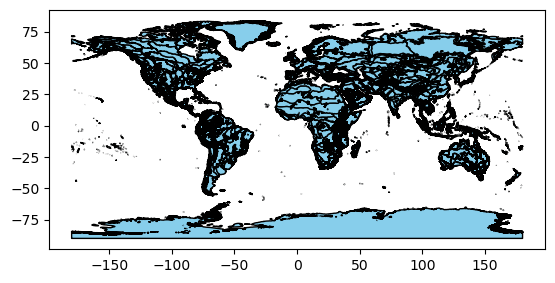

In [19]:
# Open up the ecoregions boundaries
ecoregions_gdf = (
    gpd.read_file(ecoregions_path)
    .rename(columns={
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'})
    [['name', 'area', 'geometry']]
)

# Name the index so it will match the other data later on
ecoregions_gdf.index.name = 'ecoregion'

# Plot the ecoregions to check download
ecoregions_gdf.plot(edgecolor='black', color='skyblue')

In [20]:
ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
1,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667..."


In [21]:
%store ecoregions_gdf gdf_monthly

Stored 'ecoregions_gdf' (GeoDataFrame)
Stored 'gdf_monthly' (GeoDataFrame)


Identify the ecoregion for each observation

In [22]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the coordinate reference system of the GBIF data and the ecoregions
    # transform geometries to a new coordinate reference system
    .to_crs(gdf_monthly.crs)
    # Find ecoregion for each observation
    # spatial join
    .sjoin(
        gdf_monthly,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'name']]
)
gbif_ecoregion_gdf

,month,name
ecoregion,,
4,7,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
4,7,Ahklun and Kilbuck Upland Tundra
...,...,...
833,8,Northern Rockies conifer forests
833,5,Northern Rockies conifer forests
833,5,Northern Rockies conifer forests


Count the observations in each ecoregion each month

In [23]:
def get_monthly_regional_observations(df, region_type, occurrence_name):

    occurrence_df = (
        df
        # For each region, for each month...
        .groupby([region_type, 'month'])
        # count the number of occurrences
        .agg(occurrences=(occurrence_name, 'count'))
    )

    # Get rid of rare observations (possible misidentification)
    occurrence_df = occurrence_df[occurrence_df["occurrences"] > 1]

    # Take the mean by region
    mean_occurrences_by_region = (
        occurrence_df
        .groupby([region_type])
        .mean()
    )

    # Take the mean by month
    mean_occurrences_by_month = (
        occurrence_df
        .groupby(['month'])
        .mean()
    )

    # Normalize by space and time for sampling effort
    # This accounts for the number of active observers in each location and time of year
    occurrence_df['norm_occurrences'] = (
        occurrence_df
        / mean_occurrences_by_region
        / mean_occurrences_by_month
    )

    return occurrence_df

In [24]:
occurrence_df = get_monthly_regional_observations(gbif_ecoregion_gdf, 'ecoregion', 'name')

occurrence_df

occurrences  norm_occurrences
ecoregion month                               
4         7                5          0.004534
9         5                3          0.000733
          6                2          0.001046
          8                8          0.004773
          9               13          0.007043
...                      ...               ...
833       7              167          0.004658
          8              173          0.004127
          9              128          0.002773
          10              94          0.001887
          11              25          0.000437

[780 rows x 2 columns]

Create a simplified GeoDataFrame for plot

In [25]:
"""
Streamlining plotting with hvplot by simplifying the geometry, projecting it to a Mercator projection that is compatible with
geoviews, and cropping off areas in the Arctic.
"""

# Speed up processing
ecoregions_gdf.geometry = ecoregions_gdf.simplify(
    .1, preserve_topology=False)

# Change the CRS to Mercator for mapping
ecoregions_gdf = ecoregions_gdf.to_crs(ccrs.Mercator())

ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,MULTIPOLYGON EMPTY
1,Admiralty Islands lowland rain forests,0.170599,"POLYGON ((16411777.375 -229101.376, 16384825.7..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((3391149.749 4336064.109, 33846..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((7369001.698 4093509.259, 73168..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-17930832.005 8046779.358, -17..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((14113374.546 501721.962, 14128..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((4298787.669 -137583.786, 42727..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((4267432.68 -493759.165, 428533..."


In [26]:
%store gbif_path
%who

Stored 'gbif_path' (str)
ac_CA	 ac_US	 calendar	 cartopy	 ccrs	 credentials	 data_dir	 ecoregions_dir	 ecoregions_gdf	 
ecoregions_path	 ecoregions_url	 env_variable	 first_result	 gbif_df	 gbif_dir	 gbif_ecoregion_gdf	 gbif_path	 gbif_pattern	 
gdf_monthly	 get_monthly_regional_observations	 getpass	 glob	 gpd	 gv	 hvplot	 occ	 occurrence_df	 
os	 pathlib	 pd	 pn	 prompt_func	 prompt_text	 reset_credentials	 species	 species_info	 
species_key	 time	 zipfile	 


Mapping monthly distribution

In [27]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = ecoregions_gdf.join(occurrence_df[['norm_occurrences']])

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds

# Define the slider widget
slider = pn.widgets.DiscreteSlider(
    name='month', 
    options={calendar.month_name[i]: i for i in range(1, 13)}
)

occurrence_gdf

name       area  \
ecoregion month                                                
4         7      Ahklun and Kilbuck Upland Tundra   8.196573   
9         5         Alaska-St. Elias Range tundra  28.388010   
          6         Alaska-St. Elias Range tundra  28.388010   
          8         Alaska-St. Elias Range tundra  28.388010   
          9         Alaska-St. Elias Range tundra  28.388010   
...                                           ...        ...   
833       7      Northern Rockies conifer forests  35.905513   
          8      Northern Rockies conifer forests  35.905513   
          9      Northern Rockies conifer forests  35.905513   
          10     Northern Rockies conifer forests  35.905513   
          11     Northern Rockies conifer forests  35.905513   

                                                          geometry  \
ecoregion month                                                      
4         7      MULTIPOLYGON (((-17930832.005 8046779.358, -17...   
9         5      MULTIPOLYGON (((-16886232.729 9049093.235, -16...   
          6      MULTIPOLYGON (((-16886232.729 9049093.235, -16...   
          8      MULTIPOLYGON (((-16886232.729 9049093.235, -16...   
          9      MULTIPOLYGON (((-16886232.729 9049093.235, -16...   
...                                                            ...   
833       7      POLYGON ((-13358313.218 7236575.932, -13331349...   
          8      POLYGON ((-13358313.218 7236575.932, -13331349...   
          9      POLYGON ((-13358313.218 7236575.932, -13331349...   
          10     POLYGON ((-13358313.218 7236575.932, -13331349...   
          11     POLYGON ((-13358313.218 7236575.932, -13331349...   

                 norm_occurrences  
ecoregion month                    
4         7              0.004534  
9         5              0.000733  
          6              0.001046  
          8              0.004773  
          9              0.007043  
...                           ...  
833       7              0.004658  
          8              0.004127  
          9              0.002773  
          10             0.001887  
          11             0.000437  

[780 rows x 4 columns]

In [28]:
%store occurrence_gdf

Stored 'occurrence_gdf' (GeoDataFrame)


In [29]:
occurrence_gdf.hvplot(
    x='Longitude',
    y='Latitude',
    geo=True, 
    crs=ccrs.Mercator()
    )

:Polygons   [Longitude,Latitude]

<Axes: >

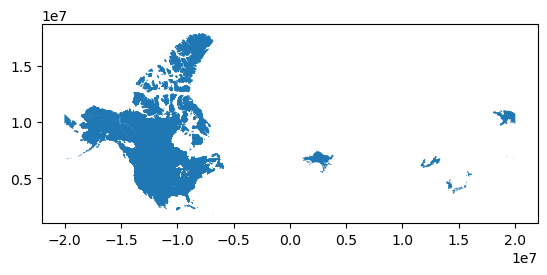

In [30]:
occurrence_gdf.plot(
)

In [31]:
occurrence_gdf['norm_occurrences']

ecoregion  month
4          7        0.004534
9          5        0.000733
           6        0.001046
           8        0.004773
           9        0.007043
                      ...   
833        7        0.004658
           8        0.004127
           9        0.002773
           10       0.001887
           11       0.000437
Name: norm_occurrences, Length: 780, dtype: float64

In [34]:
occurrence_gdf.hvplot(
    c='norm_occurrences',
    groupby='month',
    # Use background tiles
    title='Antigone canadensis Sandhill Crane Migration',
    #geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
    xlim=(xmin, xmax), ylim=(ymin, ymax),
    frame_height=600,
    colorbar=False,
    widgets={'month': slider},
    widget_location='bottom',
    width=500,
    height=500
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'55bb4923-616e-427f-b62b-3773df571642': {'version…

In [35]:
# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='month',
        # Use background tiles
        title='Antigone canadensis Sandhill Crane Migration',
        #geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        colorbar=False,
        widgets={'month': slider},
        widget_location='bottom',
        width=500,
        height=500
    )
)

# Save the plot
migration_plot.save('sandhill-crane-migration.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'7e8b270a-b6bf-4d8d-8cb3-a4ba99b307d4': {'version…

April Observations

In [36]:
occurrence_gdf_complete = occurrence_gdf.reset_index()

april_occ = occurrence_gdf_complete.loc[occurrence_gdf_complete['month'] == 4].sort_values(by=['norm_occurrences'], ascending=False)

april_occ_top_5 = april_occ[0:5]
april_occ_bottom_5 = april_occ[-5:]

In [32]:
# Top Five Ecoregions

april_occ_top_5

,ecoregion,month,name,area,geometry,occurrences,norm_occurrences
114,81,4,British Columbia coastal conifer forests,14.653986,"MULTIPOLYGON (((-14364688.43 7420408.623, -143...",29,0.006582
222,149,4,Central Tallgrass prairie,36.779324,"POLYGON ((-10534926.556 5619565.277, -10517878...",850,0.006044
553,546,4,Palouse prairie,9.866972,"MULTIPOLYGON (((-12951912.056 5827151.995, -12...",304,0.005649
255,173,4,Colorado Rockies forests,15.113154,"MULTIPOLYGON (((-12173003.318 4534115.934, -12...",307,0.005480
483,471,4,New England-Acadian forests,38.509900,"MULTIPOLYGON (((-7182650.847 5741141.666, -715...",359,0.005076


In [33]:
# Bottom Five Ecoregions

april_occ_bottom_5

,ecoregion,month,name,area,geometry,occurrences,norm_occurrences
605,639,4,Sonoran desert,21.416224,"MULTIPOLYGON (((-12499491.62 3383569.444, -124...",10,0.000089
133,88,4,California coastal sage and chaparral,3.172258,"MULTIPOLYGON (((-12820829.454 3243992.707, -12...",3,0.000087
234,162,4,Chihuahuan desert,46.807295,"MULTIPOLYGON (((-12343440.455 3790837.437, -12...",37,0.000081
704,783,4,Western Gulf coastal grasslands,8.340400,"POLYGON ((-10826974.582 3185079.852, -10843709...",17,0.000030
124,87,4,California Central Valley grasslands,4.727694,"POLYGON ((-13595834.408 4868653.384, -13554815...",9,0.000023
